In [1]:
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade setuptools -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [6]:
labeled_train_df = pd.read_csv("labeled_training_incidents.csv").rename(columns={"Unnamed: 0": "index"})
print(labeled_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             5082 non-null   int64 
 1   year              5082 non-null   int64 
 2   month             5082 non-null   int64 
 3   day               5082 non-null   int64 
 4   country           5082 non-null   object
 5   title             5082 non-null   object
 6   text              5082 non-null   object
 7   hazard-category   5082 non-null   object
 8   product-category  5082 non-null   object
 9   hazard            5082 non-null   object
 10  product           5082 non-null   object
dtypes: int64(4), object(7)
memory usage: 436.9+ KB
None


In [7]:
labeled_valid_df = pd.read_csv("labeled_validation_incidents.csv").rename(columns={"Unnamed: 0": "index"})
labeled_test_df = pd.read_csv("labeled_test_incidents.csv").rename(columns={"Unnamed: 0": "index"})

encode categorical columns before passing them to the classifier. <br>
one hot encoding for country (It's particularly suitable for nominal categorical features, where the categories have no inherent order or ranking.) <br>
Be aware of the "dummy variable trap," where multicollinearity can occur if one column can be predicted from the others..To avoid this, you can safely drop one of the one-hot encoded columns, reducing the dimensionality by one. You can declare the drop_first=True in the get_dummies function as shown below.<br>
Binary Encoding


https://kantschants.com/complete-guide-to-encoding-categorical-features#

In [8]:
# Extract unique hazard-category values and create a list
unique_hazard_categories = labeled_train_df["hazard-category"].unique().tolist()

# Create a mapping dictionary
hazard_category_mapping = {category: idx for idx, category in enumerate(unique_hazard_categories)}

# Create a new dataframe with text and hazard_category_label
train_st1_hazard = labeled_train_df[['text']].copy()
train_st1_hazard['label'] = labeled_train_df['hazard-category'].map(hazard_category_mapping)
print(train_st1_hazard.head())


                                                text  label
0  Case Number: 024-94   \n            Date Opene...      0
1  Case Number: 033-94   \n            Date Opene...      0
2  Case Number: 014-94   \n            Date Opene...      0
3  Case Number: 009-94   \n            Date Opene...      1
4  Case Number: 001-94   \n            Date Opene...      1


In [9]:
# Create a new dataframe with text and hazard_category_label
valid_st1_hazard = labeled_valid_df[['text']].copy()
valid_st1_hazard['label'] = labeled_valid_df['hazard-category'].map(hazard_category_mapping)
print(valid_st1_hazard.head())

# Create a new dataframe with text and hazard_category_label
test_st1_hazard = labeled_test_df[['text']].copy()
test_st1_hazard['label'] = labeled_test_df['hazard-category'].map(hazard_category_mapping)
print(test_st1_hazard.head())

                                                text  label
0  Case Number: 017-94   \n            Date Opene...      0
1  Case Number: 048-94   \n            Date Opene...      0
2  Case Number: 032-95   \n            Date Opene...      0
3  PRESENCE OF UNDECLARED NUTS IN ORIGINALE AUGUS...      5
4  Case Number: 018-98  Recall Notification Repor...      1
                                                text  label
0  Case Number: 039-94   \n            Date Opene...      0
1  Case Number: 026-95   \n            Date Opene...      0
2  Case Number: 028-95   \n            Date Opene...      0
3  PRA No. 1998/3500 Date published 17 Mar 1998 P...      0
4  PRA No. 1998/3645 Date published 10 Sep 1998 P...      1


TF-IDF ENCODING

Text Preprocessing with Custom Standardization <br>
This function cleans the text data:
* Converts all text to lowercase.
* Replaces newlines (\n) with a space.
* Removes punctuation.

In [10]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '\n            ', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

* The TextVectorization layer converts raw text into integer sequences.
* max_features=20000: Uses the top 20,000 words in the dataset.
* sequence_length=250: Each text sample is truncated or padded to a fixed length of 250 tokens.
* The standardize function applies the custom text cleaning we defined earlier.

In [11]:
max_features = 20000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


* The training dataset is converted into a TensorFlow Dataset.
* train_st1_hazard["text"] contains the input text.
* train_st1_hazard["label"] contains the corresponding labels.

In [12]:
# Ensure tensors are explicitly set
train_st1_hazard_ds = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1_hazard["label"].values, dtype=tf.int32)
))

# Apply mapping
text_only_train_st1_hazard_ds = train_st1_hazard_ds.map(lambda x, y: tf.cast(x, tf.string))


* The function vectorize_text() transforms text samples into numerical sequences using vectorize_layer.
* Labels are reshaped to match expected input format.

In [13]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)  # Ensure text has shape (1,)
    label = tf.expand_dims(label, -1)  # Ensure labels have shape (1,)
    label = tf.cast(label, tf.int32)  # Convert labels to integers
    return vectorize_layer(text), label

* The vectorization layer learns the vocabulary from the training data.
* The datasets (train_st1_hazard, valid_st1_hazard, test_st1_hazard) are mapped through vectorize_text() so that text inputs are converted to integer sequences.

In [14]:
vectorize_layer.adapt(text_only_train_st1_hazard_ds)
# Ensure tensors are explicitly set
train_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1_hazard["label"].values, dtype=tf.int32)
))

valid_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(valid_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(valid_st1_hazard["label"].values, dtype=tf.int32)
))

test_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(test_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(test_st1_hazard["label"].values, dtype=tf.int32)
))

train_ds = train_st1_hazard.map(vectorize_text)
val_ds = valid_st1_hazard.map(vectorize_text)
test_ds = test_st1_hazard.map(vectorize_text)

2025-02-09 17:58:24.659291: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

The model is a simple neural network for text classification:
1. Input layer: Takes integer sequences of length 250.
2. Embedding layer: Converts integer tokens into dense vector representations (size 16).
3. Dropout (0.2): Prevents overfitting.
4. GlobalAveragePooling1D: Reduces the sequence into a fixed-length vector.
5. Dropout (0.2): Further regularization.
6. Dense Layer (Softmax Activation): Outputs probabilities for 10 classes.

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=(sequence_length,)),
  layers.Embedding(max_features, 16),
  layers.Dropout(0.3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.3),
  layers.Dense(10, activation="softmax")  # Multi-class output
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 16)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,170 (1.22 MB)

 Trainable params: 320,170 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

* Loss function: SparseCategoricalCrossentropy() (used for multi-class classification).
* Optimizer: Adam optimizer (adaptive learning rate optimization).
* Metrics: Accuracy is tracked.

In [17]:
# Choose the loss function based on your labels
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),  # Use CategoricalCrossentropy if labels are one-hot
              optimizer='adam',
              metrics=["accuracy"])

* The model is trained for 20 epochs.
* Uses early stopping: Training stops if the loss does not improve for 3 consecutive epochs.

In [18]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
)

Epoch 1/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 5s 976us/step - accuracy: 0.4975 - loss: 1.6106 - val_accuracy: 0.6460 - val_loss: 1.0431
Epoch 2/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 5s 903us/step - accuracy: 0.6589 - loss: 1.0648 - val_accuracy: 0.7540 - val_loss: 0.8049
Epoch 3/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 5s 887us/step - accuracy: 0.7261 - loss: 0.8781 - val_accuracy: 0.7947 - val_loss: 0.6819
Epoch 4/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 4s 880us/step - accuracy: 0.7733 - loss: 0.7664 - val_accuracy: 0.8531 - val_loss: 0.5906
Epoch 5/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 4s 861us/step - accuracy: 0.8026 - loss: 0.6691 - val_accuracy: 0.8619 - val_loss: 0.5285
Epoch 6/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 5s 888us/step - accuracy: 0.8244 - loss: 0.5956 - val_accuracy: 0.8602 - val_loss: 0.4888
Epoch 7/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 4s 874us/step - accuracy: 0.8401 - loss: 0.5423 - val_accuracy: 0.8708 - val_loss: 0.4611
Epoch 8/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 5s 885us/step - accuracy: 0.8407 -

In [19]:
def history_plotter(history):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

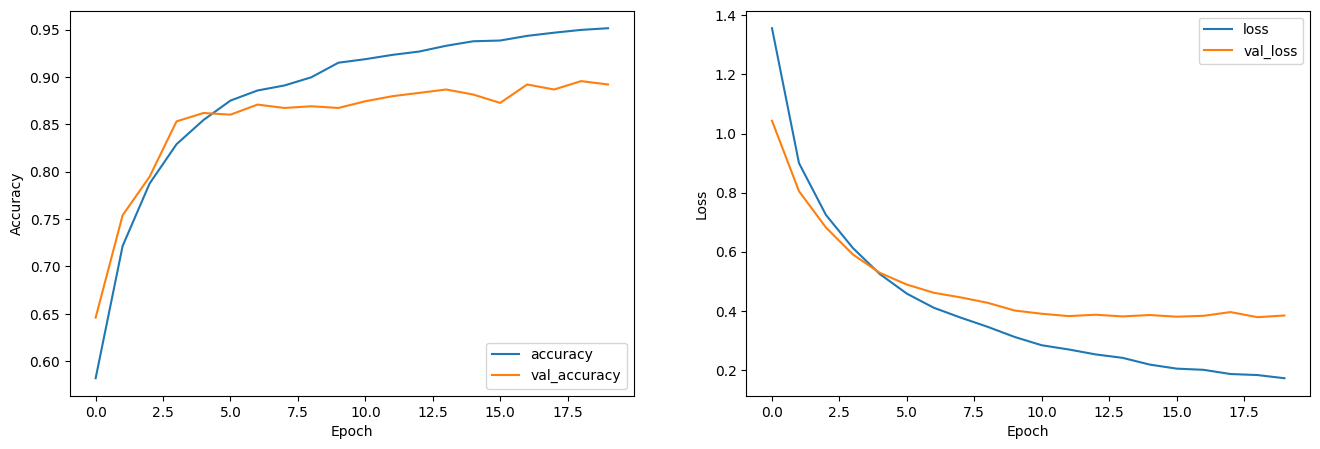

In [20]:
history_plotter(history)

In [21]:
model.evaluate(test_ds) # loss, accuracy

997/997 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - accuracy: 0.8867 - loss: 0.3904


[0.3570306897163391, 0.9017050862312317]

## Evaluation

In [22]:
def compute_score_1(hazards_true, hazards_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )
  return f1_hazards

In [23]:
# Get predictions
predictions = model.predict(test_ds)


997/997 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


In [24]:
# Convert probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

In [25]:
# Collect true labels from the dataset
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert to NumPy array
true_labels = np.array(true_labels)

2025-02-09 17:59:57.555243: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
# Generate precision, recall, and F1-score report
report = classification_report(true_labels, predicted_labels, digits=4)

# Print the report
print(report)

              precision    recall  f1-score   support

           0     0.9763    0.9621    0.9692       343
           1     0.8595    0.9369    0.8966       111
           2     0.9200    0.8846    0.9020        52
           3     0.6180    0.7333    0.6707        75
           4     1.0000    0.2000    0.3333        10
           5     0.9526    0.9370    0.9448       365
           6     0.5000    0.9000    0.6429        10
           7     0.5000    0.3462    0.4091        26
           8     1.0000    0.5000    0.6667         4
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.9017       997
   macro avg     0.7326    0.6400    0.6435       997
weighted avg     0.9069    0.9017    0.8997       997



/Users/nataliakokota/Desktop/Food Hazard Detection/Food-Hazard-Challenge/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliakokota/Desktop/Food Hazard Detection/Food-Hazard-Challenge/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliakokota/Desktop/Food Hazard Detection/Food-Hazard-Challenge/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

In [27]:
print(compute_score_1(true_labels, predicted_labels))

0.6435106644526966


In [28]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.